In [ ]:
import SFALinearPulse as sfa_lin
import extra_packages.OutputInterface as inter
import extra_packages.sperhical_expansion as spex
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from itertools import repeat

In [73]:
import multiprocessing
#import ipyparallel as ipp

try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default

pool = multiprocessing.Pool(processes=cpus)

## The aim is to compare the GTOs with the asymptotic expansion
This is to see if we perhaps can just go with the asymptotoic expansion, as it would make life a lot easier when orientation averaging, since the spherical harmonics transform nicely under rotations.

## Get the coefficients for the GTO prefactor and set parameters

In [74]:
output = inter.OutputInterface('output_files/CHBrClF.out')
Ip = abs(output.saved_orbitals[output.HOMO][0])
kappa = np.sqrt(2*Ip)
omega = 0.057     # Frequency of light
Up = 0.22         # Ponderomotive potential
CEP = np.pi/2
N = 2

gto_coeffs = np.array(output.output_GTOs())

## Obtain coefficients for asymptotic expansion

In [75]:
n_r = 50
n_l = 30
r_lst = np.linspace(1, 25, n_r)
f_lms = []
for i, r in enumerate(r_lst):
    print(f'Evaluating at r={r:.4f} \t Nr. {i+1}/{n_r}')
    f_lms.append(spex.spherical_expansion(lambda theta, phi: output.eval_orbital_spherical(r, theta, phi), 50))
f_lms = np.array(f_lms)

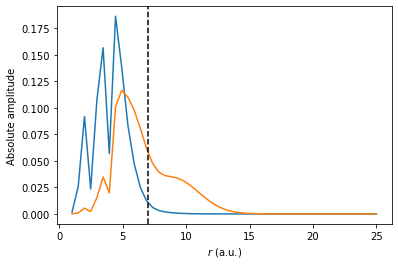

In [49]:
def radial(r):
    return r**(1/kappa - 1) * np.exp(-kappa*r)

plt.figure(facecolor='white')
sgn, l, m = 0, 8, 0
plt.plot(r_lst, np.abs(f_lms[:, sgn, l, m])*100)
plt.plot(r_lst, np.abs(f_lms[:, sgn, l, m]) / radial(r_lst))
plt.axvline(7, ls='--', color='k')                              # r = 7 seems like a solid choice!
plt.xlabel('$r$ (a.u.)')
plt.ylabel('Absolute amplitude')
plt.show()

In [67]:
clm_coeffs = spex.get_as_coeffs(output.eval_orbital_spherical, 7.0, 30, Ip, abs_thresh=1e-4)

## Calculate momentum distributions

In [68]:
dp = 4. / 100
px_lst = np.arange(-1, 1, dp)
pz_lst = np.arange(-1.5, 1.5, dp)
py = 0.
px_grd, pz_grd = np.meshgrid(px_lst, pz_lst)

# GTO
sfa_gto = sfa_lin.SFALinearPulse(Ip, Up, omega, N, CEP, 'GTO')
M_gto_grd = np.array(pool.starmap(sfa_gto.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(gto_coeffs))))
M_gto_sqr = np.abs(np.flip(M_gto_grd.T, 0))**2
print('GTO done!')

# Asymptotic
sfa_asymp = sfa_lin.SFALinearPulse(Ip, Up, omega, N, CEP, 'asymp')
M_asymp_grd = np.array(pool.starmap(sfa_asymp.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_coeffs))))
M_asymp_sqr = np.abs(np.flip(M_asymp_grd.T, 0))**2
print('Asymptotic done!')

GTO done!


KeyboardInterrupt: 

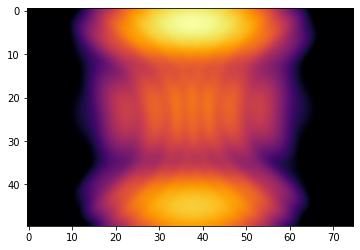

In [65]:
M = M_asymp_sqr
plt.imshow(M, interpolation='bicubic', cmap='inferno',
           norm=LogNorm(vmax=np.max(M), vmin=np.max(M)*1e-4))